这个分析笔记由[Jake Vanderplas](http://www.vanderplas.com)编辑汇总。 源代码和license文件在[GitHub](https://github.com/jakevdp/sklearn_tutorial/)。 中文翻译由[派兰数据](http://datarx.cn)在[派兰大数据分析平台](http://www.palandata.com)上完成。 源代码在[GitHub](https://github.com/palandatarxcom/sklearn_tutorial_cn)上。

# 验证和模型选择

在这一节中，我们会探索 *模型评估* 和对 *超参数* 的调整，所谓超参数就是定义模型的参数。

In [1]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn for plotting defaults
import seaborn as sns; sns.set()

## 验证模型

机器学习最重要的一部分之一就是**模型验证**：也就是，看看你训练出来的模型与给定的数据集是否相配。但是这里有几点是需要注意的。

我们回想一下我们之前看过的数字的例子，我们如何去评判一个模型的好坏呢？

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

让我们初始化一个K-neighbors分类器

In [3]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

现在让我们用这个分类器去预测数字对应的标签

In [4]:
y_pred = knn.predict(X)

最后，我们可以看一看训练模型的效果：

In [5]:
print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

1797 / 1797 correct


结果似乎表明我们有了一个完美的分类器！

**问题：错误究竟在哪里？**

## 验证集

上面我们的错误之处在于，我们在训练集上去测试我们的数据。**通常来说这不是一个好方法**。如果我们按照这种方式去优化estimator的时候，往往我们会得到**过拟合**的结果，也就是说，我们在训练时把数据的噪声也学进去了。

测试模型的一个好方法就是用未曾训练过的数据作为测试集。我们在scikit-learn的测试/训练集合划分中已经掌握了这个思想了。

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((1347, 64), (450, 64))

现在我们在训练集上进行训练，在测试集上进行验证：

In [7]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

440 / 450 correct


它给了我们一个对于模型的好坏更可信的估计。

我们这里使用的验证方法，也就是看正确个数之于总样本个数的方法，叫做**正确率**，而且我们可以使用以下的代码得到它：

In [8]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.97777777777777775

我们也可以通过``model.score``方法直接计算出来：

In [9]:
knn.score(X_test, y_test)

0.97777777777777775

通过这个验证方法，我们可以看一看当我们改变模型参数的时候，正确率是如何变化的：

In [10]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))

1 0.977777777778
5 0.977777777778
10 0.973333333333
20 0.964444444444
30 0.957777777778


我们看到在这个案例中，较小的邻居个数是较好的选择。

## 交叉验证

使用交叉验证集的一个问题就是实际上您"损失"了一部分数据。在上面的过程中，我们只用了数据集的3/4作为训练集，用了1/4作为验证集。还有一个选择就是使用**2-fold 交叉验证**，在这里我们把数据样本划分成一半对一半，然后做两次验证：

In [11]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)
X1.shape, X2.shape

((898, 64), (899, 64))

In [12]:
print(KNeighborsClassifier(1).fit(X2, y2).score(X1, y1))
print(KNeighborsClassifier(1).fit(X1, y1).score(X2, y2))

0.983296213808
0.982202447164


因此，2-fold 交叉验证给了我们对模型参数的两次估计。

因为这个过程完全手动去做可能有一些痛苦，所以scikit-learn提供了相应的包，简化了流程：

In [13]:
from sklearn.cross_validation import cross_val_score

cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=10)
cv.mean()

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.97614938602520218

### K-fold 交叉验证

在上面我们使用的是2-fold交叉验证。这个只是$k$-fold交叉验证的一个特例，在$k$-fold交叉验证中，我们将数据集划分成$k$个部分，并且做$k$次拟合。每一个部分都会轮流成为验证集。我们可以改变上面的 ``cv`` 参数去实现它。让我们接下来做10-fold的交叉验证：

In [14]:
cross_val_score(KNeighborsClassifier(1), X, y, cv=10)

array([ 0.93513514,  0.99453552,  0.97237569,  0.98888889,  0.96089385,
        0.98882682,  0.99441341,  0.98876404,  0.97175141,  0.96590909])

它让更清楚的让我们了解了自己模型的性能。

## 过拟合，欠拟合和模型选择

现在我们对验证以及交叉验证的基础知识都有了一定的了解，我们可以深入的探索模型选择的问题了。

验证和交叉验证是机器学习实践中的最重要的方面之一。如何对模型进行选择也是很重要的，但是这一点恰恰被一些进入机器学习领域的新手所忽略。

下面一些问题十分的重要：

**如果我们的estimator不能很好的工作，我们接下来应该怎么办呢？**

- 使用更简单的或者更复杂的模型？
- 给模型添加更多的特征？
- 添加更多的训练数据？

这个答案经常是违反直觉的。特别的，**有时候一个复杂的模型会给出一个 _差_ 的结果**。同时，**有时候添加训练数据的个数并不会提升你的结果**。区分成功的机器学习领域的练习者与不成功的，就是选择方法去提高模型效果的能力。

### 关于偏置和方差取舍的说明

在这一个小节中，我们将讨论一个简单的一维的回归问题。这个例子会让我们清楚直观地看到我们的数据和模型，结果可以简单的扩展到高维数据。我们来看一看 **线性回归** 的问题。我们可以用scikit-learn的`sklearn.linear_model`模块来完成这个功能。

我们创造一个简单的非线性函数供我们拟合：

In [15]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

让我们把数据集画出来：

In [16]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

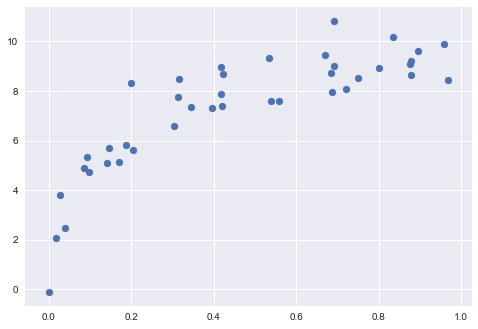

In [17]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

现在我们想在这个数据集中做回归预测。我们用集成的线性回归方法去处理一下：

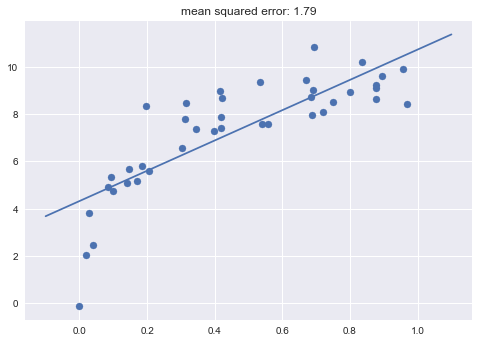

In [18]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

我们用一条直线去拟合了这一组数据，但是很明显这个模型并不是一个好的选择。这个模型对数据的拟合有**偏差**，也就是这个模型是**欠拟合**的。

让我去用更复杂的模型去提升效果。我们可以增加模型的自由度，用一个多项式级别的回归去预测我们的模型。Scikit-learn通过``PolynomialFeatures``处理器让预测变的特别简单。

我们用一个简单的方法去做：

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

现在我们用一个二次曲线去拟合这个数据：

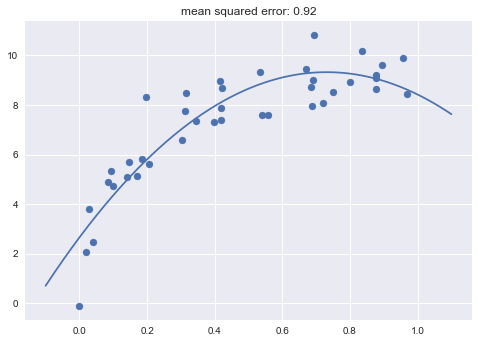

In [20]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

现在的这个拟合减少了均方差，而且比之前的拟合更优。如果我们选取更高维的多项式会有什么结果呢？

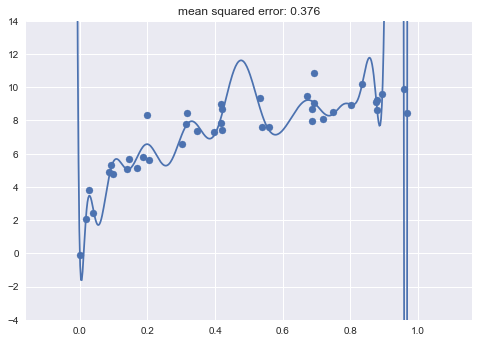

In [21]:
model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.ylim(-4, 14);

当我们将多项式的维度提高到这个程度的时候，很明显这个结果已经不再能良好的体现出数据的分布了，它对数据中的噪声变的很敏感。因此，我们叫它高方差模型，也就是说这个模型过拟合了。

我们来用IPython的交互功能（只适用于IPython 2.0+）来看一看多项式的维数对模型拟合的影响：

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


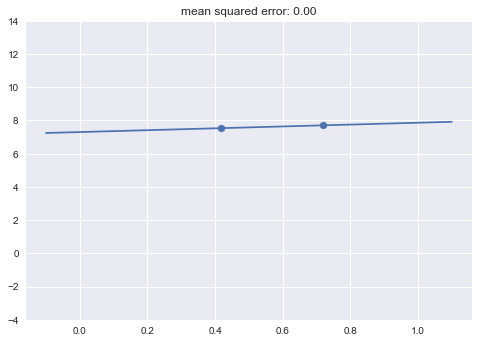

In [22]:
from IPython.html.widgets import interact

def plot_fit(degree=1, Npts=50):
    X, y = make_data(Npts, error=1)
    X_test = np.linspace(-0.1, 1.1, 500)[:, None]
    
    model = PolynomialRegression(degree=degree)
    model.fit(X, y)
    y_test = model.predict(X_test)

    plt.scatter(X.ravel(), y)
    plt.plot(X_test.ravel(), y_test)
    plt.ylim(-4, 14)
    plt.title("mean squared error: {0:.2f}".format(mean_squared_error(model.predict(X), y)))
    
interact(plot_fit, degree=[1, 30], Npts=[2, 100]);

### 通过验证曲线检测过拟合

在训练集上计算出错误显然是不够的。我们可以使用**交叉验证**的方式更好的去看一看这个模型的优劣。

我们在这里也使用``validation_curve``这个工具。为了弄明白，我们用一个稍微大一点的数据集：

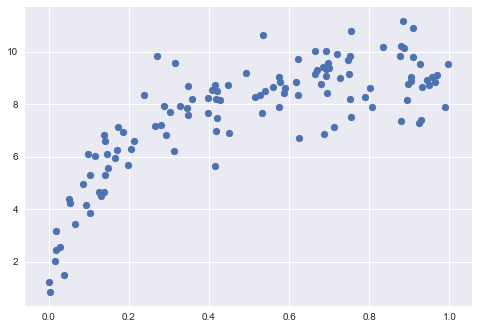

In [23]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [24]:
from sklearn.model_selection import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 18)
val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       'polynomialfeatures__degree', degree, cv=7,
                                       scoring=rms_error)

我们现在画出验证曲线：

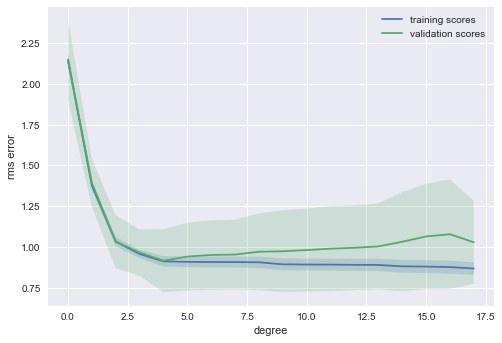

In [25]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

注意曲线的趋势，这对于这种类型的图来说很正常。

1. 对于低复杂度的模型而言，训练集上的错误率和验证集上的错误率非常的类似。这说明现在模型是**欠拟合**：它目前的复杂度不具备完好表达数据分布的能力。换个角度来说，这个模型称为**高偏置**的模型.

2. 当模型的复杂度增加的时候，训练集和验证集上的错误率开始分离开来。这表明这个模型已经**过拟合**了，它过于复杂以至于它对数据中的噪声过于敏感了。换个角度来说，这个模型称为**高方差**模型。

3. 我们需要注意到，训练的准确率几乎总是随着模型复杂度的提高而增加。这是因为越复杂的模型越能够学习噪声，所以训练的准确率会上升。验证数据通常有一个最佳位置，一般来说在度为5的时候最好。

在这里我们根据交叉验证，给出最佳拟合数据的模型：

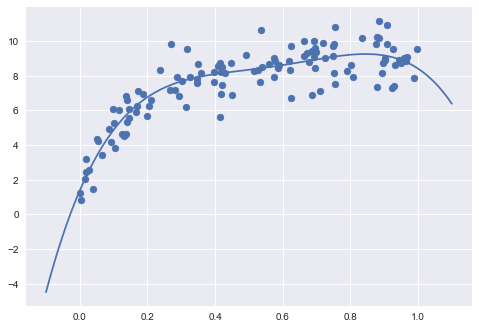

In [26]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));

### 从学习曲线中看出数据的充足与否

您可以会猜想，训练集的大小会左右训练曲线的拐点。在这里我们分析一下*学习曲线*的特点。

我们将会画出训练集和测试集数据的多少的对应的均方误差关系。

In [27]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(degree=3):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree),
                                                  X, y, train_sizes, cv=5,
                                                  scoring=rms_error)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


让我们来看一看对于一个线性的模型，它的学习曲线是长什么样子的：

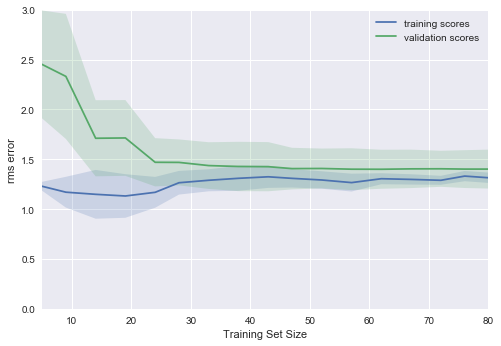

In [28]:
plot_learning_curve(1)

这是一张非常经典的学习曲线图：当数据集的点数过少的时候，在训练集和测试集上的错误率会相差很大，也就是**欠拟合**。用同样的模型，在数据量大的训练集上训练，在训练集和测试集上的错误会趋于一致，它暗示着潜在的**过拟合**。

当数据点进一步增加的时候，训练集上的错误率不再会增加，而测试集上的错误率不再会减少。（为什么你会这么认为？）

非常简单，如果你想将均方误差减小到1.0，纯粹的增加训练集的样本数是不行的。当$d$=1是，两个曲线会收敛在一起，不再会降低了。如果我们选取一个大一点的$d$呢？

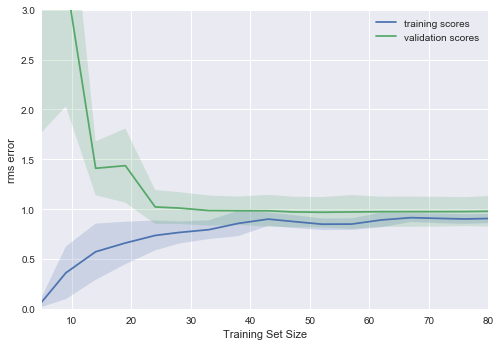

In [29]:
plot_learning_curve(3)

在这里我们看到，当模型的复杂度增加的时候，我们成功的将均方误差降低到了1.0！

如果我们继续增加模型的复杂度呢？

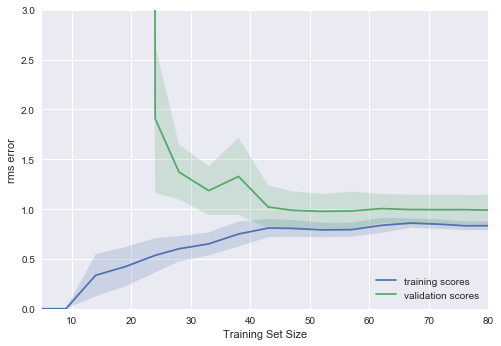

In [30]:
plot_learning_curve(10)

对于一个更复杂的模型，曲线仍然会收敛，但是这个收敛仅仅在数据量 *大* 的时候才会发生。

所以我们得到了如下的结论：

- 您可以通过增加训练集的样本数或者简化模型来**让结果收敛**.
- 您可以仅仅通过增加模型的复杂度来**将收敛的错误率降低**.

因此，这些曲线可以给你如何优化模型的提示。如果曲线已经收敛在一起了，你需要更复杂的模型。如果曲线没有收敛，你应该多加一些训练样本。

为了让上面这句话更加生动，我们举一个例子。想象一下你有一些望远镜的数据，这些数据并不是非常具有说服力。你必须思考是使用你的望远镜去获取*更多的数据去*得到一个大的训练集，还是*给每一个观测物多一些属性*。这个问题的答案非常重要，可以被这些评估方法解决。

## 总结

我们针对模型验证以及介绍了以下几种有用的方法

- **训练得分** 显示了模型在训练集上的训练效果，但这并不是模型适用性的评判标准。
- **验证得分** 显示了模型对于非训练集的数据的拟合效果。最有效的方法是，用非训练集以外的几个数据集进行交叉验证。

- **验证曲线** 是以模型复杂度为参数的训练集得分和验证集得分的曲线：
     + 当两个曲线相近的时候，代表*欠拟合* 
     + 当两个曲线逐渐分开的时候，代表*过拟合* 
     + "最佳位置"在曲线的中间 
- **学习曲线** 是以训练集样本数量为参数的训练集得分和验证集得分的曲线：
    + 当两个曲线相近的时候，代表*欠拟合*，加入更多的数据集一般来说不能提高estimator的性能
    + 当两个曲线相隔分开的时候，代表*过拟合*，加入更多的数据量可以使模型更有效
    
这些方法在您评估一个模型的时候会非常有用。